Import libraries

In [498]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

Data loading & preparation

In [499]:
# Load the datasets
catalog_df = pd.read_csv('Audible_Catlog.csv')

catalog_adv_df = pd.read_csv('Audible_Catlog_Advanced_Features.csv')

In [500]:
catalog_df.head()

,Book Name,Author,Rating,Number of Reviews,Price
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20174.0,10378.0
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4614.0,888.0
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4302.0,1005.0


In [501]:
catalog_adv_df.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."


In [502]:
catalog_df.info()
catalog_adv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          6368 non-null   object 
 1   Author             6368 non-null   object 
 2   Rating             6368 non-null   float64
 3   Number of Reviews  5737 non-null   float64
 4   Price              6365 non-null   float64
dtypes: float64(3), object(2)
memory usage: 248.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          4464 non-null   object 
 1   Author             4464 non-null   object 
 2   Rating             4464 non-null   float64
 3   Number of Reviews  4043 non-null   float64
 4   Price              4464 non-null   int64  
 5   Description        4458 non-null   object 
 6   Listening

In [503]:
catalog_df.describe()

,Rating,Number of Reviews,Price
count,6368.000000,5737.000000,6365.000000
mean,3.913709,902.786822,923.212726
std,1.663320,2454.003227,1551.750993
min,-1.000000,1.000000,0.000000
25%,4.200000,64.000000,501.000000
50%,4.500000,231.000000,680.000000
75%,4.600000,746.000000,888.000000
max,5.000000,70077.000000,18290.000000


In [504]:
catalog_adv_df.describe()

,Rating,Number of Reviews,Price
count,4464.000000,4043.000000,4464.000000
mean,3.938866,1053.490725,942.052867
std,1.628824,2825.605319,1622.056490
min,-1.000000,1.000000,0.000000
25%,4.200000,71.000000,501.000000
50%,4.500000,263.000000,683.000000
75%,4.600000,893.500000,888.000000
max,5.000000,70122.000000,18290.000000


In [505]:
# Merge the two datasets on 'Book Name' and 'Author' using an inner join to keep only matching entries
merged_df = pd.merge(
    catalog_df,
    catalog_adv_df,
    on=["Book Name", "Author"],
    suffixes=('_basic', '_adv'),
    how='inner'
)

In [506]:
merged_df.shape

(4251, 11)

In [507]:
merged_df.head()

,Book Name,Author,Rating_basic,Number of Reviews_basic,Price_basic,Rating_adv,Number of Reviews_adv,Price_adv,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20174.0,10378.0,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4614.0,888.0,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4302.0,1005.0,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."


In [508]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Book Name                4251 non-null   object 
 1   Author                   4251 non-null   object 
 2   Rating_basic             4251 non-null   float64
 3   Number of Reviews_basic  3838 non-null   float64
 4   Price_basic              4249 non-null   float64
 5   Rating_adv               4251 non-null   float64
 6   Number of Reviews_adv    3839 non-null   float64
 7   Price_adv                4251 non-null   int64  
 8   Description              4245 non-null   object 
 9   Listening Time           4251 non-null   object 
 10  Ranks and Genre          4251 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 365.4+ KB


Data cleaning

In [509]:
# Remove redundant columns (keep '_adv' versions as they contain more features)
cleaned_df = merged_df.drop(columns=['Rating_basic', 'Number of Reviews_basic', 'Price_basic'])

In [510]:
# Rename the '_adv' columns to standard names
cleaned_df.rename(columns={
    'Rating_adv': 'Rating',
    'Number of Reviews_adv': 'Number of Reviews',
    'Price_adv': 'Price'
}, inplace=True)

In [511]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Book Name          4251 non-null   object 
 1   Author             4251 non-null   object 
 2   Rating             4251 non-null   float64
 3   Number of Reviews  3839 non-null   float64
 4   Price              4251 non-null   int64  
 5   Description        4245 non-null   object 
 6   Listening Time     4251 non-null   object 
 7   Ranks and Genre    4251 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 265.8+ KB


In [512]:
# Handle missing values
# Drop rows with missing Description 
cleaned_df.dropna(subset=['Description'], inplace=True)

In [513]:
# Fill missing values for Reviews
cleaned_df['Number of Reviews'].fillna(cleaned_df['Number of Reviews'].median(), inplace=True)

In [514]:
cleaned_df.isnull().sum()

Book Name            0
Author               0
Rating               0
Number of Reviews    0
Price                0
Description          0
Listening Time       0
Ranks and Genre      0
dtype: int64

In [515]:
cleaned_df.to_csv('cleaned.csv')

In [516]:
def convert_listening_time(time_str):
    if not isinstance(time_str, str):
        return np.nan
    
    # Treat '-1' or similar invalid entries as missing
    if time_str.strip() == '-1':
        return np.nan

    # Normalize units
    time_str = time_str.lower().replace("hrs", "hours").replace("hr", "hour")
    time_str = time_str.replace("mins", "minutes").replace("min", "minute")

    # Initialize values
    hours = 0
    minutes = 0

    hour_match = re.search(r'(\d+)\s*hour', time_str)
    minute_match = re.search(r'(\d+)\s*minute', time_str)

    if hour_match:
        hours = int(hour_match.group(1))
    if minute_match:
        minutes = int(minute_match.group(1))

    return hours * 60 + minutes

In [517]:
cleaned_df['Listening Time (mins)'] = cleaned_df['Listening Time'].apply(convert_listening_time)

In [518]:
cleaned_df.head()

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre,Listening Time (mins)
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top...",654.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top...",203.0
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top...",317.0
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top...",335.0
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top...",385.0


In [519]:
# Fill missing values for Listening Time (mins)
cleaned_df['Listening Time (mins)'].fillna(cleaned_df['Listening Time (mins)'].median(), inplace=True)

In [520]:
cleaned_df.duplicated().sum()

np.int64(669)

In [521]:
# Remove duplicates
cleaned_df.drop_duplicates(subset=['Book Name', 'Author'], inplace=True)

In [522]:
# drop unnecessary original columns
cleaned_df = cleaned_df.drop(columns=['Listening Time'])

In [523]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   float64
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Ranks and Genre        3346 non-null   object 
 7   Listening Time (mins)  3346 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 235.3+ KB


In [524]:
# Pattern to identify and remove junk genre entries (e.g., %, star ratings, empty segments, stray punctuation)
junk_pattern = re.compile(
    r'^\s*[,0-9%\s\(\)star]+$'       # only punctuation/numbers/percent/star
    r'|^\s*[-1]+$'                   # -1 or similar
    r'|^,.*%.*,$'                    # odd percent patterns
    r'|^,.*star.*,$'                 # odd star patterns
    r'|^,.*$'                        # trailing commas only
    r'|^\s*books?\)?[^\w]*$'
    r'|\b(?:audible\s+audio(?:books)?\s*&\s*originals|audible\s+originals)\b'  # remove Audible Audiobooks & Originals
    , flags=re.IGNORECASE
)

from collections import OrderedDict

def extract_genres(genre_str):
    """Extract genres from 'Ranks and Genre'.
       - split ONLY on comma or '(' (so spaces inside genres are preserved)
       - capture token after 'in' up to a comma or '('
       - drop tokens starting with '#' or that begin with digits or are pure numbers
       - drop Audible-brand tokens and obvious junk (stars/percents)
    """
    if pd.isna(genre_str) or str(genre_str).strip() == '':
        return []
    s = str(genre_str)

    # split only on comma or '(' so spaces inside genre names remain
    parts = re.split(r',|\(', s)

    genres = []
    junk_re = re.compile(r'(^\s*$)|(\bstar\b)|(%$)|(^\s*[-1]+\s*$)', re.IGNORECASE)

    for part in parts:
        part = part.strip()
        if not part:
            continue

        # prefer "#NN in <genre>" capturing up to comma or '(' (we already split on '(' so stop at comma/end)
        m = re.search(r'#\d+\s+in\s+([^,]+)', part, flags=re.IGNORECASE)
        if m:
            candidate = m.group(1).strip()
        else:
            m2 = re.search(r'\bin\s+([^,]+)', part, flags=re.IGNORECASE)
            candidate = m2.group(1).strip() if m2 else part

        # remove trailing noise like percentages, colons, asterisks, etc.
        candidate = re.sub(r'[%*:].*', '', candidate).strip(' ,.-:;')

        # remove exact Audible-brand tokens
        if re.search(r'\b(?:audible\s+audio(?:books)?\s*&\s*originals|audible\s+originals)\b', candidate, flags=re.IGNORECASE):
            continue

        # skip tokens that start with '#' or are purely numeric or start with a digit
        if candidate.startswith('#'):
            continue
        if re.match(r'^\d+(\.\d+)?$', candidate):  # purely numeric
            continue
        if re.match(r'^\d', candidate):  # starts with a digit (e.g., "5 star")
            continue

        # skip other junk patterns
        if junk_re.search(candidate) or junk_pattern.match(candidate):
            continue

        # final normalization
        candidate = re.sub(r'\s+', ' ', candidate).strip()
        if candidate:
            genres.append(candidate)

    return list(OrderedDict.fromkeys(genres))

# create 'Genre' column from 'Ranks and Genre'
cleaned_df['Genre'] = cleaned_df['Ranks and Genre'].apply(extract_genres)

In [525]:
# Count how many books have genres
books_with_genres = cleaned_df['Genre'].apply(len) > 0
print(f"Books with genre information: {books_with_genres.sum()}")

Books with genre information: 1781


In [526]:
# Get all unique genres
all_genres = []
for genre_list in cleaned_df['Genre']:
    all_genres.extend(genre_list)

unique_genres = list(set(all_genres))
print(f"Total unique genres found: {len(unique_genres)}")
print()

Total unique genres found: 851



In [527]:
# Display most common genres
from collections import Counter
genre_counts = Counter(all_genres)
print(" Top 20 Most Common Genres:")
for genre, count in genre_counts.most_common(20):
    print(f"  {genre}: {count}")

 Top 20 Most Common Genres:
  Personal Success: 180
  Personal Development & Self-Help: 144
  Analysis & Strategy: 108
  Textbooks & Study Guides: 98
  Leadership: 68
  Contemporary Fiction: 64
  Classic Literature: 61
  Literary Fiction: 59
  Crime: 54
  Thriller & Mystery: 54
  Biographies & Autobiographies: 54
  Historical Fiction: 47
  Psychology: 45
  Romance: 43
  Contemporary Romance: 42
  Meditation: 41
  Business Careers: 41
  Business Management: 41
  Mind: 40
  Body & Spirit: 40


In [528]:
# If Genre is a list per row:
cleaned_df['Genre'].explode().value_counts(dropna=False)

Genre
NaN                                 1565
Personal Success                     180
Personal Development & Self-Help     144
Analysis & Strategy                  108
Textbooks & Study Guides              98
                                    ... 
US State & Local History               1
Hard-Boiled Mysteries                  1
Diaries & Journals                     1
Divination                             1
Journalism Books                       1
Name: count, Length: 852, dtype: int64

In [529]:
cleaned_df['Genre'] = cleaned_df['Genre'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else None)

In [530]:
# Create a subset with known genres and descriptions
known_genres = cleaned_df[cleaned_df['Genre'].notnull()]
unknown_genres = cleaned_df[cleaned_df['Genre'].isnull()]

In [531]:
# Vectorize descriptions using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_known = vectorizer.fit_transform(known_genres['Description'])
tfidf_unknown = vectorizer.transform(unknown_genres['Description'])

In [532]:
# Use Nearest Neighbors to find closest match by description
nn = NearestNeighbors(n_neighbors=1, metric='cosine')
nn.fit(tfidf_known)

,n_neighbors,1
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [533]:
# Predict genres for missing entries
distances, indices = nn.kneighbors(tfidf_unknown)
predicted_genres = known_genres.iloc[indices.flatten()]['Genre'].values

In [534]:
# Fill in the predicted genres
cleaned_df.loc[cleaned_df['Genre'].isnull(), 'Genre'] = predicted_genres

In [535]:
# Check genre
filled_genre_counts = cleaned_df['Genre'].value_counts().head(10)
cleaned_df[['Book Name', 'Genre']].head(), filled_genre_counts

(                                           Book Name  \
 0  Think Like a Monk: The Secret of How to Harnes...   
 1  Ikigai: The Japanese Secret to a Long and Happ...   
 2  The Subtle Art of Not Giving a F*ck: A Counter...   
 3  Atomic Habits: An Easy and Proven Way to Build...   
 4  Life's Amazing Secrets: How to Find Balance an...   
 
                                                Genre  
 0  [Personal Success, Stress Management, Society ...  
 1        [Meditation, Self-Esteem, Personal Success]  
 2  [Personal Success, Personal Development & Self...  
 3  [Psychology, Stress Management, Personal Success]  
 4            [Literary Essays, Essays, Spiritualism]  ,
 Genre
 [Religion & Philosophy, Hinduism, Theology & Philosophy of Religion]    755
 [Fantasy]                                                               432
 [Personal Success, Personal Development & Self-Help]                     66
 [Classic Literature, Classic Fiction]                                    17
 [Ec

In [536]:
# Convert 'Number of Reviews' to integer type
cleaned_df['Number of Reviews'] = cleaned_df['Number of Reviews'].astype(int)

In [537]:
# drop unnecessary original columns
cleaned_df = cleaned_df.drop(columns=['Ranks and Genre'])

In [538]:
cleaned_df

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time (mins),Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371,10080,"Over the past three years, Jay Shetty has beco...",654.0,"[Personal Success, Stress Management, Society ..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682,615,Brought to you by Penguin.,203.0,"[Meditation, Self-Esteem, Personal Success]"
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306,10378,"In this generation-defining self-help guide, a...",317.0,"[Personal Success, Personal Development & Self..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678,888,Brought to you by Penguin.,335.0,"[Psychology, Stress Management, Personal Success]"
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308,1005,"Stop going through life, Start growing throug...",385.0,"[Literary Essays, Essays, Spiritualism]"
...,...,...,...,...,...,...,...,...
4228,Make Today Count: The Secret of Your Success I...,John C. Maxwell,4.7,307,500,"Sorry, we just need to make sure you're not a ...",485.5,"[Religion & Philosophy, Hinduism, Theology & P..."
4230,वॉयर - एक कामुक लघुकथा,सेसिलि रोसडैल,-1.0,267,65,"Sorry, we just need to make sure you're not a ...",485.5,"[Religion & Philosophy, Hinduism, Theology & P..."
4232,द गेम विद मिस्टर एक्‍स - एक कामुक लघुकथा,ओलरिक,-1.0,267,32,"Sorry, we just need to make sure you're not a ...",485.5,"[Religion & Philosophy, Hinduism, Theology & P..."
4234,"Kill the Company: End the Status Quo, Start an...",Lisa Bodell,4.2,26,586,\n\nOops!\nIt's rush hour and traffic is pilin...,485.5,[Fantasy]


In [539]:
cleaned_df.isnull().sum()

Book Name                0
Author                   0
Rating                   0
Number of Reviews        0
Price                    0
Description              0
Listening Time (mins)    0
Genre                    0
dtype: int64

In [540]:
cleaned_df['Rating']

0       4.9
1       4.6
2       4.4
3       4.6
4       4.6
       ... 
4228    4.7
4230   -1.0
4232   -1.0
4234    4.2
4235    4.6
Name: Rating, Length: 3346, dtype: float64

In [541]:
cleaned_df["Rating"].replace(-1.0, np.nan, inplace=True)

In [542]:
cleaned_df['Rating'].isnull().sum()

np.int64(319)

In [543]:
cleaned_df["Rating"].fillna(cleaned_df["Rating"].median(), inplace=True)

In [544]:
cleaned_df = cleaned_df[(cleaned_df["Rating"] >= 0) & (cleaned_df["Rating"] <= 5)]

In [545]:
cleaned_df['Rating'].unique()

array([4.9, 4.6, 4.4, 4.1, 4.5, 3.6, 5. , 4. , 4.2, 4.8, 4.7, 3.4, 3.9,
       4.3, 3. , 3.8, 2.5, 2. , 3.5, 2.4, 1. , 3.1, 3.2, 3.7, 3.3, 1.9,
       2.6, 2.7, 2.9])

In [546]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346 entries, 0 to 4235
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Book Name              3346 non-null   object 
 1   Author                 3346 non-null   object 
 2   Rating                 3346 non-null   float64
 3   Number of Reviews      3346 non-null   int64  
 4   Price                  3346 non-null   int64  
 5   Description            3346 non-null   object 
 6   Listening Time (mins)  3346 non-null   float64
 7   Genre                  3346 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 235.3+ KB


In [547]:
cleaned_df.to_csv('cleaned_book_data.csv',index=False)

Exploratory Data Analysis

In [548]:
# Read the dataset
df = pd.read_csv('cleaned_book_data.csv')

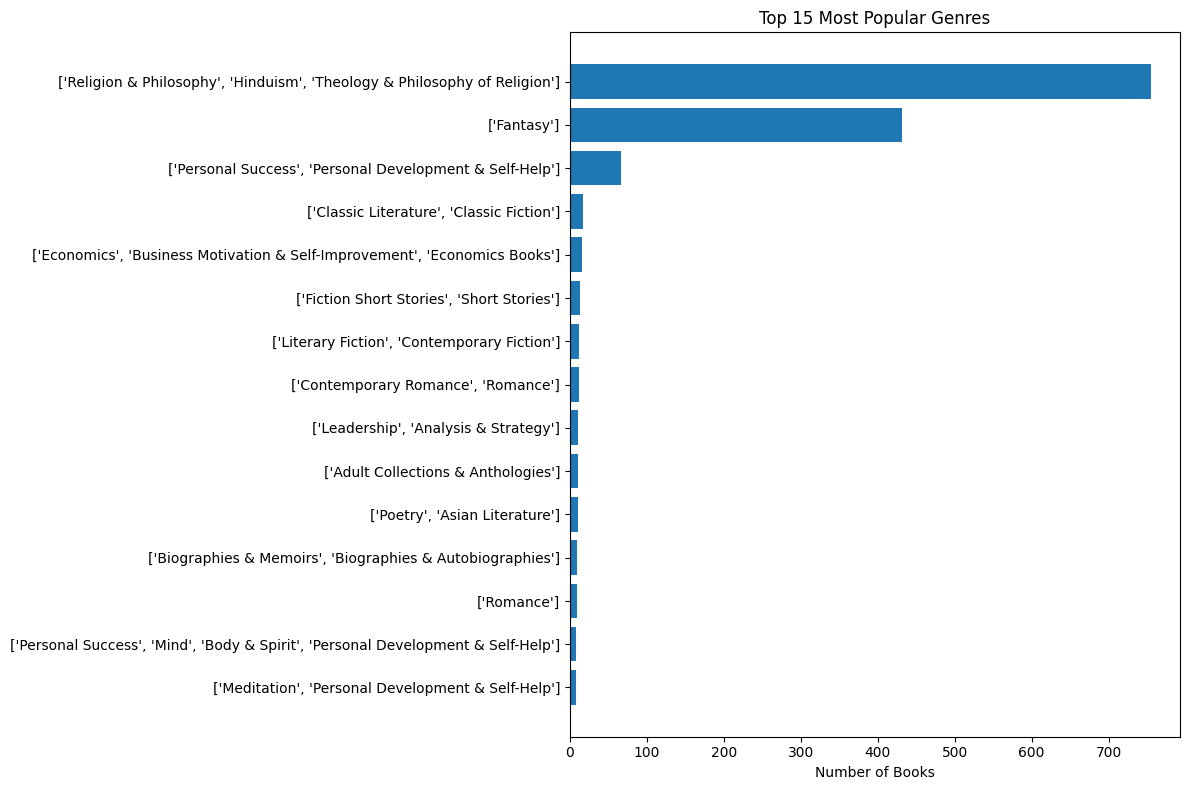

In [549]:
#Easy level
# Question 1: Most popular genres


plt.figure(figsize=(12, 8))
top_15_genres = df['Genre'].value_counts().head(15)
plt.barh(range(len(top_15_genres)), top_15_genres.values)
plt.yticks(range(len(top_15_genres)), top_15_genres.index)
plt.xlabel('Number of Books')
plt.title('Top 15 Most Popular Genres')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [550]:
# Question 2: Authors with highest-rated books

# Get authors with at least 2 books for meaningful comparison
author_stats = df.groupby('Author').agg({
    'Rating': ['mean', 'count'],
    'Number of Reviews': 'sum'
}).round(2)
author_stats.columns = ['Avg_Rating', 'Book_Count', 'Total_Reviews']
author_stats = author_stats[author_stats['Book_Count'] >= 2]  # Authors with 2+ books
top_rated_authors = author_stats.sort_values('Avg_Rating', ascending=False).head(10)

print("Top 10 Highest-Rated Authors (with 2+ books):")
for i, (author, stats) in enumerate(top_rated_authors.iterrows(), 1):
    print(f"{i:2d}. {author}: {stats['Avg_Rating']:.2f} avg rating ({stats['Book_Count']} books)")

Top 10 Highest-Rated Authors (with 2+ books):
 1. Vikram Sampath: 4.90 avg rating (2.0 books)
 2. Timothy Zahn: 4.85 avg rating (2.0 books)
 3. John Ramirez: 4.85 avg rating (2.0 books)
 4. J. Krishnamurti: 4.80 avg rating (3.0 books)
 5. Kate DiCamillo: 4.80 avg rating (2.0 books)
 6. Michel Danino: 4.80 avg rating (2.0 books)
 7. E.J. Noyes: 4.80 avg rating (2.0 books)
 8. Isabel Wilkerson: 4.80 avg rating (2.0 books)
 9. Joel Osteen: 4.80 avg rating (2.0 books)
10. Watchman Nee: 4.80 avg rating (2.0 books)


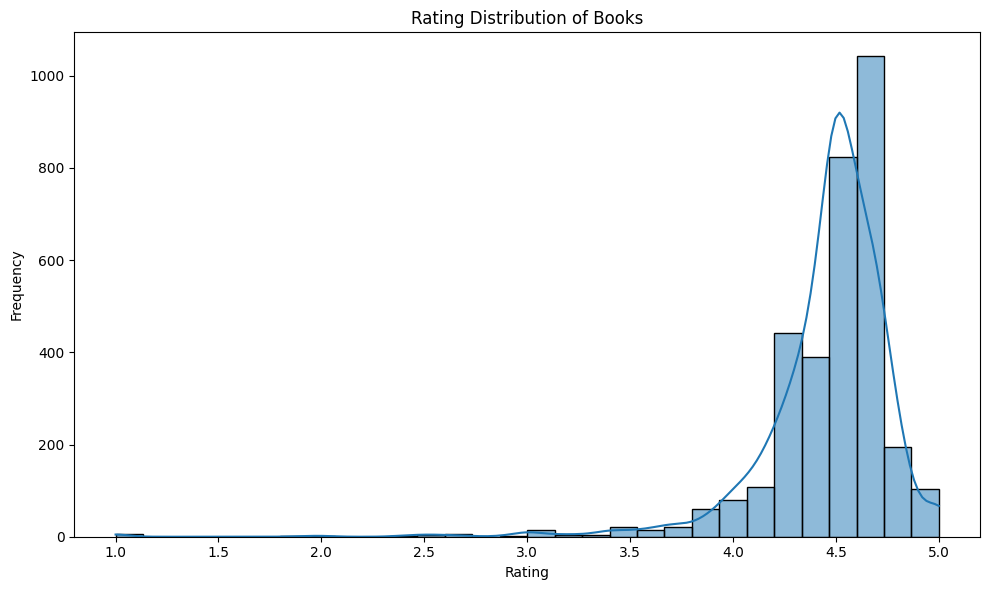

In [551]:
# Question 3: Average rating distribution


plt.figure(figsize=(10, 6))

sns.histplot(df['Rating'], kde=True, bins=30)

plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Rating Distribution of Books")
plt.tight_layout()
plt.show()


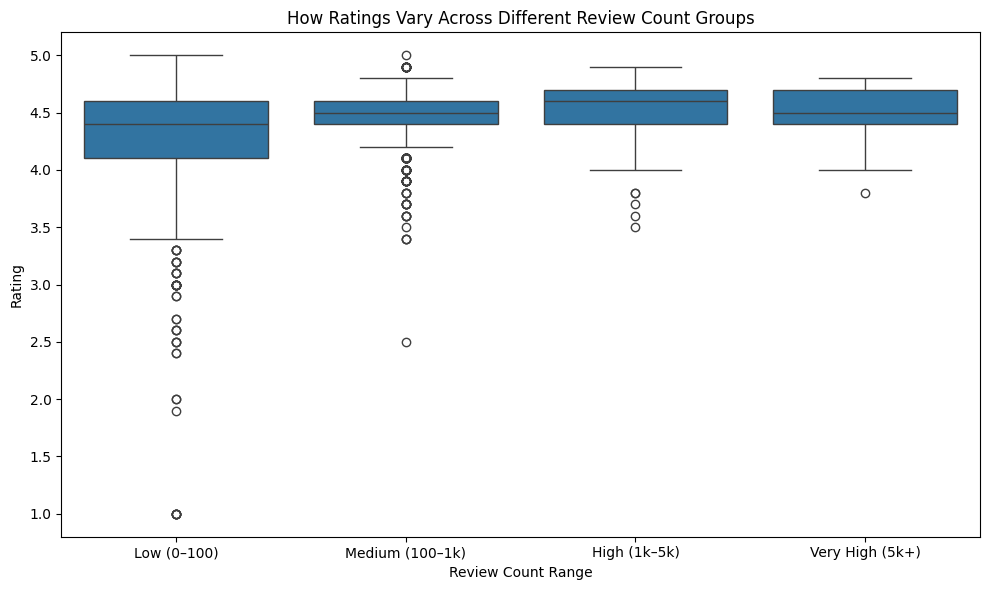

In [552]:
# Question 4: Ratings vs Review counts


# ----- Create review count bins -----
bins = [0, 100, 1000, 5000, df['Number of Reviews'].max()]
labels = ['Low (0–100)', 'Medium (100–1k)', 'High (1k–5k)', 'Very High (5k+)']

df['Review_Bin'] = pd.cut(df['Number of Reviews'], bins=bins, labels=labels, include_lowest=True)

# ----- Plot: Boxplot for Ratings across Review Count Groups -----
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Review_Bin', y='Rating')

plt.xlabel("Review Count Range")
plt.ylabel("Rating")
plt.title("How Ratings Vary Across Different Review Count Groups")
plt.tight_layout()
plt.show()


In [553]:
#Medium level
#Question 1: Genre similarity affect on book recommendations

# Find books that share similar genre keywords
genre_keywords = {}

for genre in df['Genre'].unique():

    # --- CLEAN GENRE STRING ---
    g = str(genre)                     # convert list → string
    g = g.replace("[", "")             # remove [
    g = g.replace("]", "")             # remove ]
    g = g.replace("'", "")             # remove '
    g = g.replace(",", "")             # remove ,
    g = g.strip()                      # remove leading/trailing spaces

    # Split into words
    words = g.lower().split()

    for word in words:
        if word not in ['&', 'for', 'and', 'of', 'the', 'in', 'on']:
            if word not in genre_keywords:
                genre_keywords[word] = []
            genre_keywords[word].append(g)

# Find most common genre keywords
keyword_counts = {k: len(v) for k, v in genre_keywords.items()}
top_keywords = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("Most common genre keywords:")
for i, (keyword, count) in enumerate(top_keywords, 1):
    print(f"{i:2d}. '{keyword}': appears in {count} different genres")


Most common genre keywords:
 1. 'fiction': appears in 488 different genres
 2. 'business': appears in 253 different genres
 3. 'personal': appears in 226 different genres
 4. 'history': appears in 202 different genres
 5. 'children': appears in 167 different genres
 6. 'biographies': appears in 166 different genres
 7. 'literature': appears in 149 different genres
 8. 'success': appears in 121 different genres
 9. 'science': appears in 121 different genres
10. 'fantasy': appears in 106 different genres


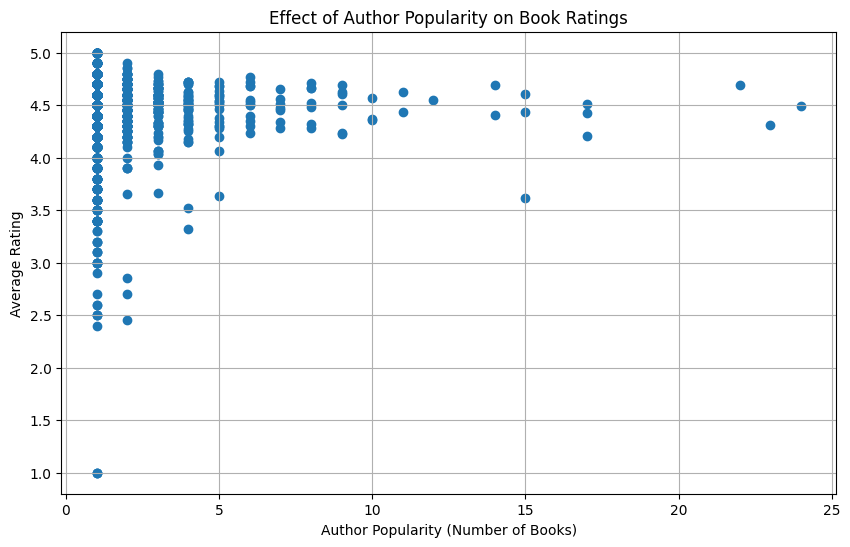

In [554]:
# Question 2: Effect of author popularity on book ratings

# Calculate author popularity (# of books)
author_popularity = df.groupby('Author')['Book Name'].count().reset_index()
author_popularity.columns = ['Author', 'Book_Count']

# Calculate average rating per author
author_ratings = df.groupby('Author')['Rating'].mean().reset_index()
author_ratings.columns = ['Author', 'Avg_Rating']

# Merge
author_stats = author_popularity.merge(author_ratings, on='Author')

# Plot
plt.figure(figsize=(10,6))
plt.scatter(author_stats['Book_Count'], author_stats['Avg_Rating'])
plt.xlabel("Author Popularity (Number of Books)")
plt.ylabel("Average Rating")
plt.title("Effect of Author Popularity on Book Ratings")
plt.grid(True)
plt.show()


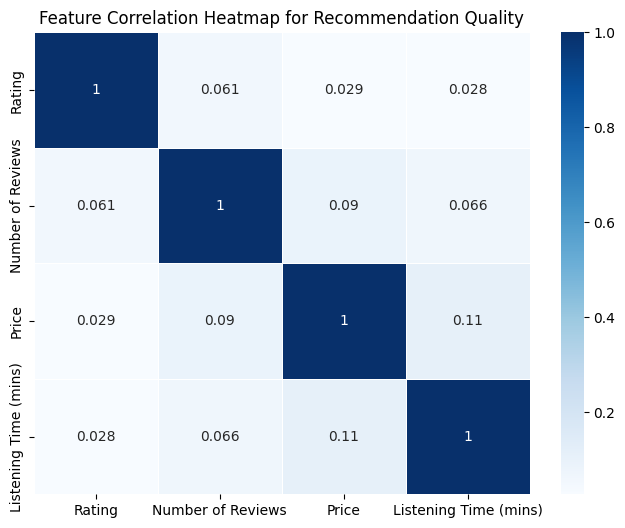

In [555]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns useful for recommendation modeling
num_cols = ['Rating', 'Number of Reviews', 'Price', 'Listening Time (mins)']  # modify based on your dataset

corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="Blues", linewidths=0.5)
plt.title("Feature Correlation Heatmap for Recommendation Quality")
plt.show()


In [556]:
#Scenario Based
# Recommend top 5 highest-rated Science Fiction books

sci_fi_books = df[df['Genre'].str.contains('Science Fiction', case=False, na=False)]
top_sci_fi = sci_fi_books.nlargest(5, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews']]
print("Recommended Science Fiction books:")
for i, (_, book) in enumerate(top_sci_fi.iterrows(), 1):
    print(f"{i}. '{book['Book Name']}' by {book['Author']}")
    print(f"   Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}")

Recommended Science Fiction books:
1. 'Saving the Sun Dragon: Dragon Masters, Book 2' by Tracey West
   Rating: 4.9, Reviews: 588
2. 'Revenge of the Invisible Boy: Goosebumps Slappyworld, Book 9' by R.L. Stine
   Rating: 4.9, Reviews: 245
3. 'So Long, Lollipops: The Free Until The End of the World Novella' by Sarah Lyons Fleming
   Rating: 4.8, Reviews: 174
4. 'Morning Star: Book III of the Red Rising Trilogy' by Pierce Brown
   Rating: 4.8, Reviews: 3016
5. 'The Martian' by Andy Weir
   Rating: 4.7, Reviews: 33293


In [557]:
#highest-rated Thriller/Mystery books

thriller_books = df[df['Genre'].str.contains('Thriller|Mystery|Crime', case=False, na=False)]
top_thrillers = thriller_books.nlargest(5, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews']]
print("Recommended Thriller/Mystery books:")
for i, (_, book) in enumerate(top_thrillers.iterrows(), 1):
    print(f"{i}. '{book['Book Name']}' by {book['Author']}")
    print(f"   Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}")

Recommended Thriller/Mystery books:
1. 'Sherlock Holmes: The Definitive Collection' by Arthur Conan Doyle
   Rating: 5.0, Reviews: 6
2. 'Blasphemy: The Trial of Danesh Masih' by Osman Haneef
   Rating: 4.9, Reviews: 13
3. 'Saving the Sun Dragon: Dragon Masters, Book 2' by Tracey West
   Rating: 4.9, Reviews: 588
4. 'Poirot's Finest Cases: Eight Full-Cast BBC Radio Dramatisations' by Agatha Christie
   Rating: 4.8, Reviews: 27
5. 'More of Poirot's Finest Cases: Seven Full-Cast BBC Radio Dramatisations' by Agatha Christie
   Rating: 4.8, Reviews: 12


In [558]:
#Hidden gems (high rating, low popularity)

# Define hidden gems as books with rating >= 4.5 and reviews < 500
hidden_gems = df[(df['Rating'] >= 4.5) & (df['Number of Reviews'] < 500)]
hidden_gems_sorted = hidden_gems.nlargest(10, 'Rating')[['Book Name', 'Author', 'Rating', 'Number of Reviews', 'Genre']]
print("Top 10 Hidden Gems:")
for i, (_, book) in enumerate(hidden_gems_sorted.iterrows(), 1):
    print(f"{i:2d}. '{book['Book Name']}' by {book['Author']}")
    print(f"    Rating: {book['Rating']}, Reviews: {book['Number of Reviews']}, Genre: {book['Genre']}")

Top 10 Hidden Gems:
 1. 'The Sandman' by Neil Gaiman
    Rating: 5.0, Reviews: 1, Genre: ['Epic Fantasy', 'Dark Fantasy', 'Fantasy']
 2. 'Sherlock Holmes: The Definitive Collection' by Arthur Conan Doyle
    Rating: 5.0, Reviews: 6, Genre: ['Private Investigator Mysteries', 'Crime', 'Thriller & Mystery']
 3. 'F*cking History: 111 Lessons You Should Have Learned in School' by The Captain
    Rating: 5.0, Reviews: 185, Genre: ['Love & Romance', 'Humour', 'Family & Relationships']
 4. 'No Calculator? No Problem!: Mastering Mental Math' by Art Benjamin
    Rating: 5.0, Reviews: 1, Genre: ['Education']
 5. 'Satyajit Ray Ki Kahaniyan [Stories of Satyajit Ray]' by Satyajit Rai
    Rating: 5.0, Reviews: 1, Genre: ['Fiction Short Stories', 'Short Stories']
 6. 'The Ultimate Jim Rohn Library' by Jim Rohn
    Rating: 5.0, Reviews: 1, Genre: ['Personal Success', 'Personal Development & Self-Help']
 7. '50 Self-Help Classics to Guide You to Financial Freedom' by Napoleon Hill
    Rating: 5.0, Revie

Additional Insights

In [559]:
#Average Rating for Genres

genre_counts = df['Genre'].value_counts()
top_10_genres = genre_counts.head(10)

print("\nAverage Ratings for Top 10 Genres:")

for genre in top_10_genres.index:
    avg_rating = df[df['Genre'] == genre]['Rating'].mean()
    print(f"- {genre}: {avg_rating:.2f}")



Average Ratings for Top 10 Genres:
- ['Religion & Philosophy', 'Hinduism', 'Theology & Philosophy of Religion']: 4.46
- ['Fantasy']: 4.45
- ['Personal Success', 'Personal Development & Self-Help']: 4.33
- ['Classic Literature', 'Classic Fiction']: 4.36
- ['Economics', 'Business Motivation & Self-Improvement', 'Economics Books']: 4.51
- ['Fiction Short Stories', 'Short Stories']: 4.39
- ['Literary Fiction', 'Contemporary Fiction']: 4.49
- ['Contemporary Romance', 'Romance']: 4.48
- ['Leadership', 'Analysis & Strategy']: 4.58
- ['Adult Collections & Anthologies']: 3.67


In [560]:
# Authors with Most Books

top_authors = df['Author'].value_counts().head(10)

print("\nTop 10 Most Common Authors:")
for i, (author, count) in enumerate(top_authors.items(), 1):
    print(f"{i:2d}. {author}: {count} books")



Top 10 Most Common Authors:
 1. Harvard Business Review: 24 books
 2. Devdutt Pattanaik: 23 books
 3. Rick Riordan: 22 books
 4. Robin Sharma: 17 books
 5. OSHO: 17 books
 6. Innovative Language Learning: 17 books
 7. Jeff Kinney: 15 books
 8. Shanaya Taneja: 15 books
 9. Ruskin Bond: 15 books
10. Brian Tracy: 14 books


In [561]:
# Genre Diversity Among Authors

author_genre_diversity = df.groupby('Author')['Genre'].nunique().sort_values(ascending=False)
diverse_authors = author_genre_diversity[author_genre_diversity > 1].head(10)
print("Most genre-diverse authors:")
for i, (author, genre_count) in enumerate(diverse_authors.items(), 1):
    book_count = df[df['Author'] == author].shape[0]
    print(f"{i:2d}. {author}: {genre_count} different genres ({book_count} books)")

Most genre-diverse authors:
 1. Devdutt Pattanaik: 20 different genres (23 books)
 2. Harvard Business Review: 18 different genres (24 books)
 3. Rick Riordan: 11 different genres (22 books)
 4. Agatha Christie: 10 different genres (12 books)
 5. Roald Dahl: 10 different genres (14 books)
 6. Robin Sharma: 10 different genres (17 books)
 7. Brian Tracy: 9 different genres (14 books)
 8. Thich Nhat Hanh: 8 different genres (9 books)
 9. Dale Carnegie: 8 different genres (10 books)
10. Paulo Coelho: 8 different genres (9 books)


In [562]:
#High Rating and Popularity Combination

# Filter high-rated books with many reviews
high_rated_popular = df[(df['Rating'] >= 4.8) & (df['Number of Reviews'] >= 5000)]

# Sort by highest rating + highest reviews
high_rated_popular = high_rated_popular.sort_values(
    by=['Rating', 'Number of Reviews'], ascending=False
)

# Show top 20 (or change number as needed)
high_rated_popular[['Book Name', 'Author', 'Rating', 'Number of Reviews']].head(10)


,Book Name,Author,Rating,Number of Reviews
408,The Nightingale,Kristin Hannah,4.8,40958
266,The Five Love Languages: The Secret to Love Th...,Gary Chapman,4.8,16390
28,Can't Hurt Me: Master Your Mind and Defy the Odds,David Goggins,4.8,11336
256,"The Body Keeps the Score: Mind, Brain and Body...",Bessel van der Kolk,4.8,8278
1550,The Gruffalo,Julia Donaldson,4.8,7370
2721,Go the F--k to Sleep,Adam Mansbach,4.8,7179
1115,The Hate U Give,Angie Thomas,4.8,7015
1123,"Salt, Fat, Acid, Heat: Mastering the Elements ...",Samin Nosrat,4.8,6023
1682,Charlotte's Web,E. B. White,4.8,5072
1770,A Court of Wings and Ruin,Sarah J. Maas,4.8,5017


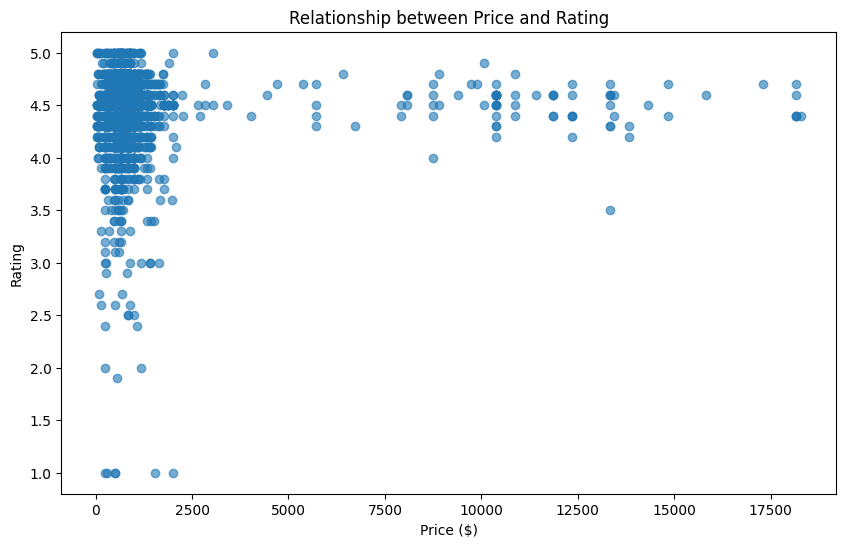

In [563]:
# Price vs Rating analysis
paid_books = df[df['Price'] > 0]
plt.figure(figsize=(10, 6))
plt.scatter(paid_books['Price'], paid_books['Rating'], alpha=0.6)
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.title('Relationship between Price and Rating')
plt.show()

NLP and Clustering

In [564]:
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [565]:
df = pd.read_csv('cleaned_book_data.csv')

In [566]:
# Preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [567]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

In [568]:
# Combine and clean text
df['combined_text'] = df['Book Name'].fillna('') + ' ' + df['Description'].fillna('')
df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

In [569]:
# TF-IDF with n-grams and min_df
tfidf = TfidfVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2
)
X_text = tfidf.fit_transform(df['cleaned_text'])

In [570]:
# One-hot encode Genre
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_encoded = encoder.fit_transform(df[['Genre']].fillna('Unknown'))

In [571]:
# Log-transform and scale numerical features
num_features = df[['Rating', 'Number of Reviews', 'Price', 'Listening Time (mins)']].copy()
num_features['Number of Reviews'] = np.log1p(num_features['Number of Reviews'])
num_features['Price'] = np.log1p(num_features['Price'])
scaler = MinMaxScaler()
structured_scaled = scaler.fit_transform(num_features)

In [572]:
# Combine features
from scipy.sparse import hstack
X_combined = hstack([X_text, structured_scaled, genre_encoded])

In [573]:
# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=30, random_state=42)
X_umap = reducer.fit_transform(X_combined)

In [574]:
# KMeans Clustering
best_k = None
best_score = -1
silhouette_scores = {}
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, init='k-means++')
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores[k] = score
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_kmeans_model = kmeans

In [575]:
df['KMeans_Cluster'] = best_labels

In [576]:
# KMeans Evaluation
kmeans_sil = silhouette_score(X_umap, df['KMeans_Cluster'])
kmeans_ch = calinski_harabasz_score(X_umap, df['KMeans_Cluster'])
kmeans_db = davies_bouldin_score(X_umap, df['KMeans_Cluster'])

In [577]:
print("\n✅ KMeans Scores:")
print(f"Best k: {best_k}")
print(f"Silhouette Score: {kmeans_sil:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.2f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")


✅ KMeans Scores:
Best k: 4
Silhouette Score: 0.6884
Calinski-Harabasz Score: 7054.61
Davies-Bouldin Index: 0.3616


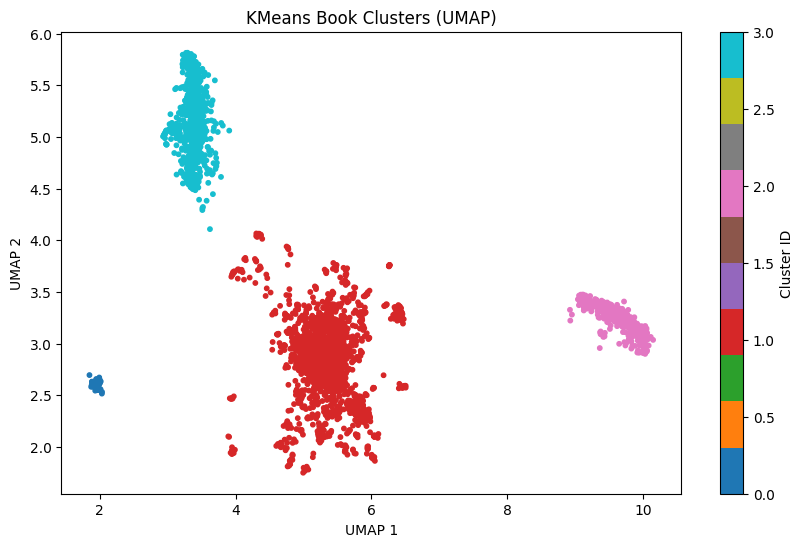

In [578]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['KMeans_Cluster'], cmap='tab10', s=10)
plt.title('KMeans Book Clusters (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [579]:
# For KMeans
for c in sorted(df['KMeans_Cluster'].unique()):
    print(f"\nKMeans Cluster {c}:")
    print(df[df['KMeans_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))


KMeans Cluster 0:
                                             Book Name  \
5                             Extraordinary Leadership   
13   The Alchemist: A Fable About Following Your Dream   
45                                 Think and Grow Rich   
123                                   The Fountainhead   
243                               Crime and Punishment   

                                                 Genre  Rating  
5                   ['Leadership', 'Business Careers']     4.1  
13   ['Metaphysical & Visionary Fiction', 'Literary...     4.6  
45   ['Economics', 'Business Motivation & Self-Impr...     4.5  
123  ['Crime', 'Thriller & Mystery', 'Classic Ficti...     4.2  
243  ['Russian Literature', 'Literary History & Cri...     4.4  

KMeans Cluster 1:
                                           Book Name  \
0  Think Like a Monk: The Secret of How to Harnes...   
1  Ikigai: The Japanese Secret to a Long and Happ...   
2  The Subtle Art of Not Giving a F*ck: A Counter...   

In [580]:
# --- DBSCAN Clustering ---
best_dbscan_score = -1
best_dbscan_eps = None
best_dbscan_labels = None
best_dbscan_model = None

In [581]:
for eps in np.arange(0.2, 1.0, 0.05):
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(X_umap)
    # Ignore runs where all points are noise or only 1 cluster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        continue
    mask = labels != -1
    if np.sum(mask) == 0:
        continue
    score = silhouette_score(X_umap[mask], labels[mask])
    print(f"DBSCAN eps={eps:.2f} ➤ clusters={n_clusters}, silhouette={score:.4f}")
    if score > best_dbscan_score:
        best_dbscan_score = score
        best_dbscan_eps = eps
        best_dbscan_labels = labels
        best_dbscan_model = dbscan

DBSCAN eps=0.20 ➤ clusters=73, silhouette=0.3353
DBSCAN eps=0.25 ➤ clusters=78, silhouette=0.2763
DBSCAN eps=0.30 ➤ clusters=95, silhouette=0.2766
DBSCAN eps=0.35 ➤ clusters=89, silhouette=0.4877
DBSCAN eps=0.40 ➤ clusters=75, silhouette=0.5129
DBSCAN eps=0.45 ➤ clusters=59, silhouette=0.3961
DBSCAN eps=0.50 ➤ clusters=46, silhouette=0.3424
DBSCAN eps=0.55 ➤ clusters=39, silhouette=0.3246
DBSCAN eps=0.60 ➤ clusters=31, silhouette=0.2873
DBSCAN eps=0.65 ➤ clusters=28, silhouette=0.3255
DBSCAN eps=0.70 ➤ clusters=26, silhouette=0.3205
DBSCAN eps=0.75 ➤ clusters=22, silhouette=0.3492
DBSCAN eps=0.80 ➤ clusters=20, silhouette=0.3747
DBSCAN eps=0.85 ➤ clusters=18, silhouette=0.3913
DBSCAN eps=0.90 ➤ clusters=16, silhouette=0.3904
DBSCAN eps=0.95 ➤ clusters=15, silhouette=0.4122


In [582]:
df['DBSCAN_Cluster'] = best_dbscan_labels


✅ Best DBSCAN Scores:
Best eps: 0.40
Silhouette Score: 0.5129
Calinski-Harabasz Score: 1073.71
Davies-Bouldin Index: 0.7085


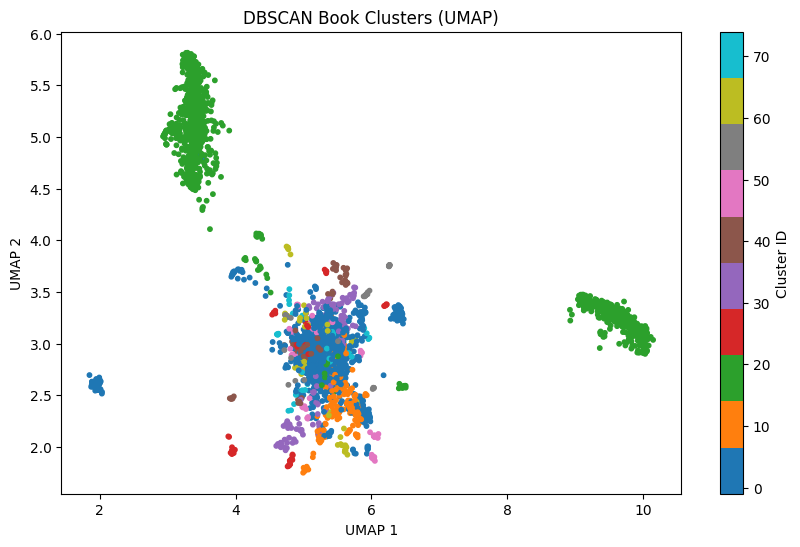

In [583]:
# DBSCAN Evaluation
if best_dbscan_labels is not None:
    mask = best_dbscan_labels != -1
    dbscan_sil = silhouette_score(X_umap[mask], best_dbscan_labels[mask])
    dbscan_ch = calinski_harabasz_score(X_umap[mask], best_dbscan_labels[mask])
    dbscan_db = davies_bouldin_score(X_umap[mask], best_dbscan_labels[mask])
    print("\n✅ Best DBSCAN Scores:")
    print(f"Best eps: {best_dbscan_eps:.2f}")
    print(f"Silhouette Score: {dbscan_sil:.4f}")
    print(f"Calinski-Harabasz Score: {dbscan_ch:.2f}")
    print(f"Davies-Bouldin Index: {dbscan_db:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['DBSCAN_Cluster'], cmap='tab10', s=10)
    plt.title('DBSCAN Book Clusters (UMAP)')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar(label='Cluster ID')
    plt.show()

In [584]:
# For DBSCAN (ignore noise points, i.e., -1)
for c in sorted(df['DBSCAN_Cluster'].unique()):
    if c == -1: continue  # Skip noise
    print(f"\nDBSCAN Cluster {c}:")
    print(df[df['DBSCAN_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))


DBSCAN Cluster 0:
                                            Book Name  \
0   Think Like a Monk: The Secret of How to Harnes...   
6                                             Sapiens   
9   The 5AM Club: Own Your Morning. Elevate Your L...   
11            Influence: The Psychology of Persuasion   
12                                        The Sandman   

                                                Genre  Rating  
0   ['Personal Success', 'Stress Management', 'Soc...     4.9  
6         ['Anthropology', 'History of Civilization']     4.6  
9   ['Sleep Disorders', 'Personal Success', 'Healt...     4.4  
11  ['Consumer Behaviour', 'Marketing', 'Earth Sci...     4.4  
12        ['Epic Fantasy', 'Dark Fantasy', 'Fantasy']     5.0  

DBSCAN Cluster 1:
                                            Book Name  \
1   Ikigai: The Japanese Secret to a Long and Happ...   
3   Atomic Habits: An Easy and Proven Way to Build...   
15                            Thinking, Fast and Slow   
20     

In [585]:
# --- HDBSCAN CLUSTERING ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,           # Try 3–10 for small datasets
    min_samples=5,                # Try 3–10 for small datasets
    metric='euclidean',           # You can also try 'manhattan' or 'cosine'
    cluster_selection_method='eom',
    prediction_data=True
)
hdb_labels = clusterer.fit_predict(X_umap)
df['HDBSCAN_Cluster'] = hdb_labels

In [586]:
# --- EVALUATION ---
mask = hdb_labels != -1
n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
if n_clusters > 1 and np.sum(mask) > 0:
    hdb_sil = silhouette_score(X_umap[mask], hdb_labels[mask])
    hdb_ch = calinski_harabasz_score(X_umap[mask], hdb_labels[mask])
    hdb_db = davies_bouldin_score(X_umap[mask], hdb_labels[mask])
    print("\n✅ HDBSCAN Scores:")
    print(f"Clusters found: {n_clusters}")
    print(f"Silhouette Score: {hdb_sil:.4f}")
    print(f"Calinski-Harabasz Score: {hdb_ch:.2f}")
    print(f"Davies-Bouldin Index: {hdb_db:.4f}")
else:
    print("HDBSCAN found less than 2 clusters or all noise.")


✅ HDBSCAN Scores:
Clusters found: 74
Silhouette Score: 0.6563
Calinski-Harabasz Score: 1283.37
Davies-Bouldin Index: 0.6025


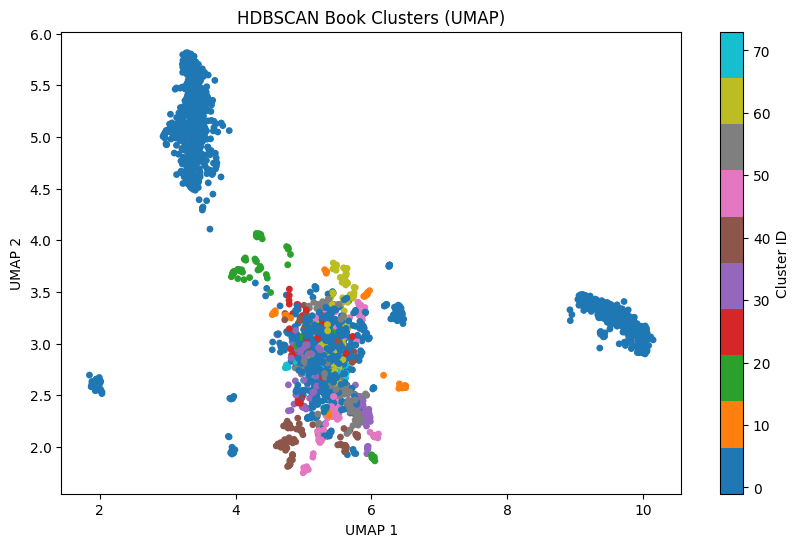

In [587]:
# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdb_labels, cmap='tab10', s=15)
plt.title('HDBSCAN Book Clusters (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [588]:
# Show size and example books per cluster
cluster_counts = df['HDBSCAN_Cluster'].value_counts().sort_values(ascending=False)
print(cluster_counts)

# Example: Show top 5 books from 3 largest clusters
for c in cluster_counts.index[:3]:
    print(f"\nCluster {c} (size={cluster_counts[c]}):")
    print(df[df['HDBSCAN_Cluster'] == c][['Book Name', 'Genre', 'Rating']].head(5))

HDBSCAN_Cluster
-1     921
 3     757
 1     432
 73     89
 65     75
      ... 
 40      6
 38      6
 42      6
 8       6
 20      6
Name: count, Length: 75, dtype: int64

Cluster -1 (size=921):
                                            Book Name  \
0   Think Like a Monk: The Secret of How to Harnes...   
4   Life's Amazing Secrets: How to Find Balance an...   
8   Rich Dad Poor Dad: What the Rich Teach Their K...   
9   The 5AM Club: Own Your Morning. Elevate Your L...   
11            Influence: The Psychology of Persuasion   

                                                Genre  Rating  
0   ['Personal Success', 'Stress Management', 'Soc...     4.9  
4       ['Literary Essays', 'Essays', 'Spiritualism']     4.6  
8   ['Personal Finance', 'Investing & Trading', 'P...     4.5  
9   ['Sleep Disorders', 'Personal Success', 'Healt...     4.4  
11  ['Consumer Behaviour', 'Marketing', 'Earth Sci...     4.4  

Cluster 3 (size=757):
                                            Book Na

In [589]:
# --- Save Models and Results ---
with open('tfidf_vectorizer_improved.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('kmeans_model_improved.pkl', 'wb') as f:
    pickle.dump(best_kmeans_model, f)
with open('dbscan_model_best.pkl', 'wb') as f:
    pickle.dump(best_dbscan_model, f)
with open('hdbscan_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)
with open('umap_model.pkl', 'wb') as f:
    pickle.dump(reducer, f)

In [590]:
df.to_csv('clustered_books_improved.csv', index=False)

Content-Based Recommendations

In [591]:
df = pd.read_csv('clustered_books_improved.csv')

In [592]:
# Fill NaNs in cleaned_text if needed
df['cleaned_text'] = df['cleaned_text'].fillna('')

In [593]:
def build_content_model(df):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim, tfidf

Clustering & Hybrid Baded Recommendations

In [594]:
def recommend_content(title, df, cosine_sim, top_n=5):
    indices = pd.Series(df.index, index=df['Book Name']).drop_duplicates()
    idx = indices.get(title)
    if idx is None:
        return []
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    book_indices = [i[0] for i in sim_scores]
    return df['Book Name'].iloc[book_indices].tolist()

def recommend_by_cluster(title, df, cluster_col='KMeans_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def recommend_by_cluster_dbscan(title, df, cluster_col='DBSCAN_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def recommend_by_cluster_hdbscan(title, df, cluster_col='HDBSCAN_Cluster', top_n=5):
    book_cluster = df.loc[df['Book Name'] == title, cluster_col]
    if book_cluster.empty or book_cluster.values[0] == -1:
        return []
    cluster_books = df[df[cluster_col] == book_cluster.values[0]]
    return cluster_books[cluster_books['Book Name'] != title]['Book Name'].head(top_n).tolist()

def hybrid_recommend(title, df, cosine_sim, cluster_col='KMeans_Cluster', top_n=5):
    content_recs = set(recommend_content(title, df, cosine_sim, top_n*2))
    cluster_recs = set(recommend_by_cluster(title, df, cluster_col, top_n*2))
    hybrid = list(content_recs & cluster_recs)
    if len(hybrid) < top_n:
        hybrid = list(content_recs | cluster_recs)
    return hybrid[:top_n]

In [595]:
#Evaluation metrics

def evaluate_recommendation(df, rec_func, cosine_sim=None, cluster_col='KMeans_Cluster', top_n=5):
    y_true, y_pred = [], []
    for idx, row in df.iterrows():
        true_cluster = int(row[cluster_col])
        if rec_func == recommend_content:
            recs = rec_func(row['Book Name'], df, cosine_sim, top_n=top_n)
        elif rec_func == hybrid_recommend:
            recs = rec_func(row['Book Name'], df, cosine_sim, cluster_col=cluster_col, top_n=top_n)
        else:
            recs = rec_func(row['Book Name'], df, cluster_col=cluster_col, top_n=top_n)
        pred_clusters = df[df['Book Name'].isin(recs)][cluster_col].values
        for pc in pred_clusters:
            y_true.append(true_cluster)
            y_pred.append(pc)
    return {
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Accuracy': accuracy_score(y_true, y_pred)
    }

In [596]:
if __name__ == "__main__":
    cosine_sim, tfidf = build_content_model(df)
    results = []

    # Content-based (using KMeans for evaluation)
    content_metrics = evaluate_recommendation(df, recommend_content, cosine_sim, cluster_col='KMeans_Cluster')
    # KMeans cluster-based
    kmeans_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='KMeans_Cluster')
    # DBSCAN cluster-based
    dbscan_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='DBSCAN_Cluster')
    # HDBSCAN cluster-based
    hdbscan_metrics = evaluate_recommendation(df, recommend_by_cluster, None, cluster_col='HDBSCAN_Cluster')
    # Hybrid (content + KMeans)
    hybrid_metrics_kmeans = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='KMeans_Cluster')
    # Hybrid (content + DBSCAN)
    hybrid_metrics_dbscan = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='DBSCAN_Cluster')
    # Hybrid (content + HDBSCAN)
    hybrid_metrics_hdbscan = evaluate_recommendation(df, hybrid_recommend, cosine_sim, cluster_col='HDBSCAN_Cluster')

    results.append({'Method': 'Content-Based', **content_metrics})
    results.append({'Method': 'KMeans Cluster-Based', **kmeans_metrics})
    results.append({'Method': 'DBSCAN Cluster-Based', **dbscan_metrics})
    results.append({'Method': 'HDBSCAN Cluster-Based', **hdbscan_metrics})
    results.append({'Method': 'Hybrid (Content+KMeans)', **hybrid_metrics_kmeans})
    results.append({'Method': 'Hybrid (Content+DBSCAN)', **hybrid_metrics_dbscan})
    results.append({'Method': 'Hybrid (Content+HDBSCAN)', **hybrid_metrics_hdbscan})

    summary_df = pd.DataFrame(results)
    print("\n=== Recommendation Evaluation Summary ===")
    print(summary_df.round(4))
    summary_df.to_csv("recommendation_evaluation_summary.csv", index=False)


=== Recommendation Evaluation Summary ===
                     Method  Precision  Recall  F1-Score  Accuracy
0             Content-Based     0.8082  0.9268    0.8513    0.8507
1      KMeans Cluster-Based     0.9996  0.9956    0.9975    0.9994
2      DBSCAN Cluster-Based     1.0000  0.9997    0.9999    0.9993
3     HDBSCAN Cluster-Based     0.9866  0.9867    0.9867    0.9996
4   Hybrid (Content+KMeans)     0.9136  0.9710    0.9393    0.9414
5   Hybrid (Content+DBSCAN)     0.5910  0.5272    0.5299    0.7025
6  Hybrid (Content+HDBSCAN)     0.5509  0.5784    0.5461    0.6725


In [600]:
sample_title = "Dream With Your Eyes Open: An Entrepreneurial Journey"
print("\n🔍 Sample Recommendations (Content-Based):")
print(recommend_content(sample_title, df, cosine_sim))

print("\n🔍 Sample Recommendations (KMeans Cluster-Based):")
print(recommend_by_cluster(sample_title, df, cluster_col='KMeans_Cluster'))

print("\n🔍 Sample Recommendations (DBSCAN Cluster-Based):")
print(recommend_by_cluster(sample_title, df, cluster_col='DBSCAN_Cluster')) 

print("\n🔍 Sample Recommendations (HDBSCAN Cluster-Based):")
print(recommend_by_cluster(sample_title, df, cluster_col='HDBSCAN_Cluster'))

print("\n🔍 Sample Recommendations (Hybrid, KMeans):")
print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='KMeans_Cluster'))
print("\n🔍 Sample Recommendations (Hybrid, DBSCAN):")
print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='DBSCAN_Cluster'))

print("\n🔍 Sample Recommendations (Hybrid, HDBSCAN):")
print(hybrid_recommend(sample_title, df, cosine_sim, cluster_col='HDBSCAN_Cluster'))

# SAVE MODELS
with open('cosine_sim_new.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)
with open('tfidf_new.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('kmeans_model_n.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
with open('dbscan_model_n.pkl', 'wb') as f:
    pickle.dump(dbscan, f)
with open('hdbscan_model_n.pkl', 'wb') as f:
    pickle.dump(clusterer, f)
print("\n✅ Models and evaluation summary saved.")


🔍 Sample Recommendations (Content-Based):
['Entrepreneurial Leap: Do You Have What it Takes to Become an Entrepreneur?', 'Get a Grip: An Entrepreneurial Fable - Your Journey to Get Real, Get Simple, and Get Results', 'The Startup Way: How Entrepreneurial Management Transforms Culture and Drives Growth', 'Evil Eye', 'The Girl of My Dreams']

🔍 Sample Recommendations (KMeans Cluster-Based):
['Think Like a Monk: The Secret of How to Harness the Power of Positivity and Be Happy Now', 'Ikigai: The Japanese Secret to a Long and Happy Life', 'The Subtle Art of Not Giving a F*ck: A Counterintuitive Approach to Living a Good Life', 'Atomic Habits: An Easy and Proven Way to Build Good Habits and Break Bad Ones', "Life's Amazing Secrets: How to Find Balance and Purpose in Your Life"]

🔍 Sample Recommendations (DBSCAN Cluster-Based):
['A Space of Her Own: Personal Narratives of Twelve Women', 'The Hospital: The FREE Short Story: The First Mountain Man Story', 'The Girl with a Plan: Love in Times 